In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import shap
from lime.lime_tabular import LimeTabularExplainer

In [50]:
data = pd.read_csv("wnba_clean.csv")

In [52]:
selected_features = ['coordinate_x', 'coordinate_y', 'distance', 'shot_group_encoded', 'shot_type_encoded']

In [53]:
X = data[selected_features]
y = data['made_shot']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Decision Tree
For easier visualization and explanainability we will use low depth

In [62]:
# Initialize and train Decision Tree
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)  
dt_model.fit(X_train, y_train)

# Model evaluation
y_pred = dt_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6616867469879518

Classification Report:
               precision    recall  f1-score   support

       False       0.61      0.81      0.70      6030
        True       0.75      0.52      0.61      6420

    accuracy                           0.66     12450
   macro avg       0.68      0.67      0.66     12450
weighted avg       0.68      0.66      0.65     12450



### InModeling XAI

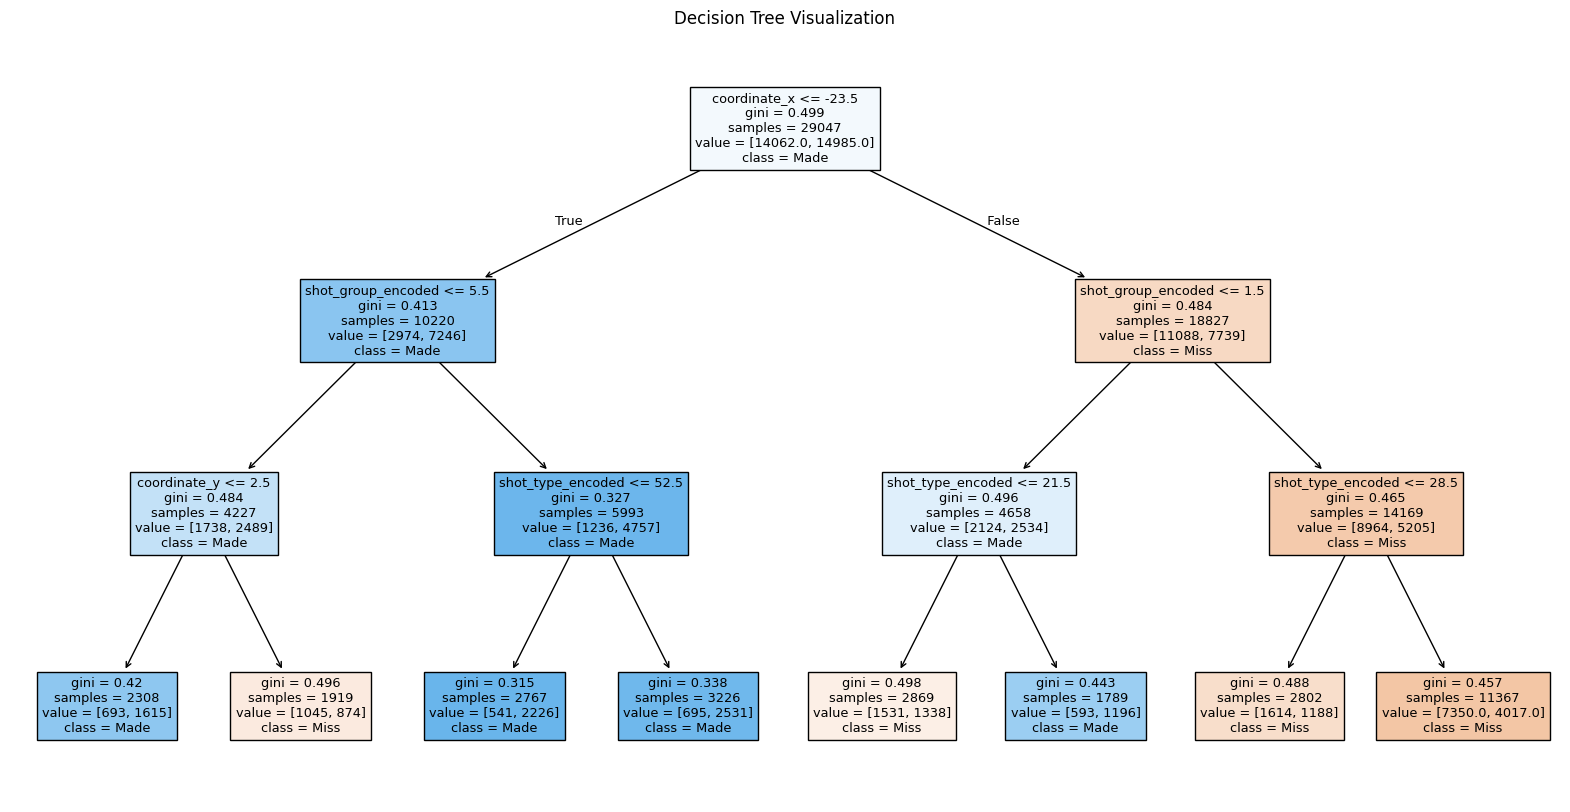

In [63]:
# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns, class_names=['Miss', 'Made'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

### Post Hoc XAI

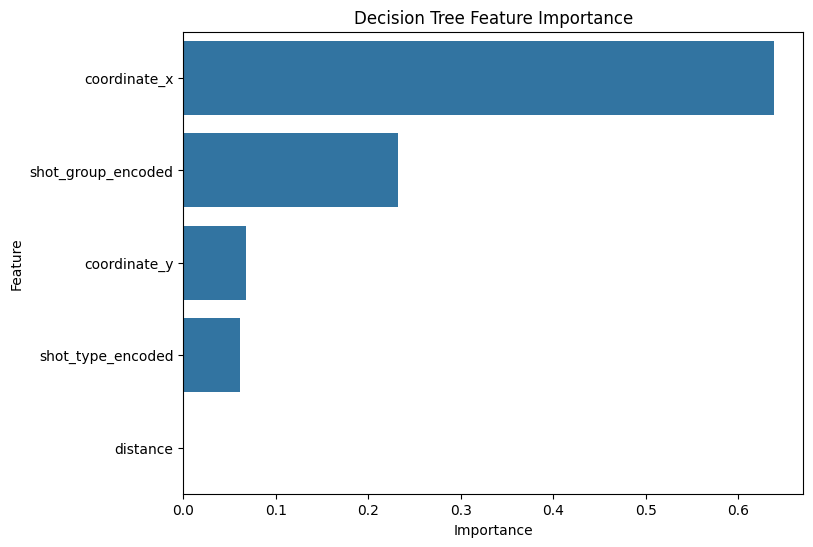

In [64]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Decision Tree Feature Importance')
plt.show()


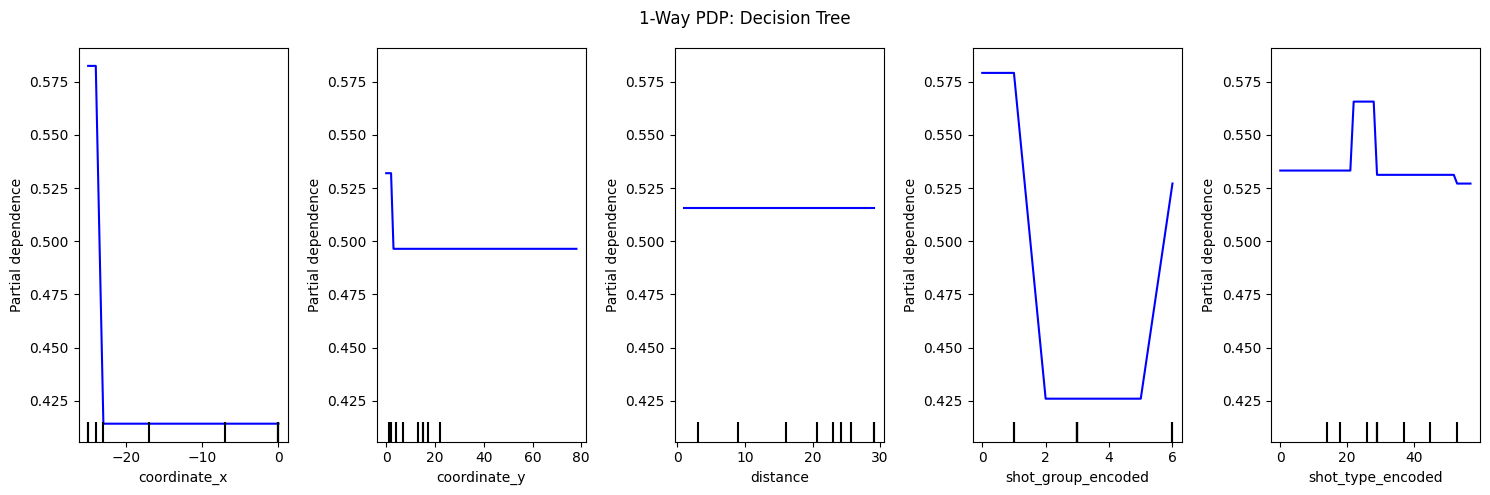

In [58]:

# 1-way PDP for both models (individual features)
features = [0, 1, 2, 3, 4]  # Adjust these to your features' indices
fig, axs = plt.subplots(1, len(features), figsize=(15, 5))
PartialDependenceDisplay.from_estimator(dt_model, X_train, features, ax=axs, line_kw={"color": "blue"})
plt.suptitle("1-Way PDP: Decision Tree")
plt.tight_layout()
plt.show()


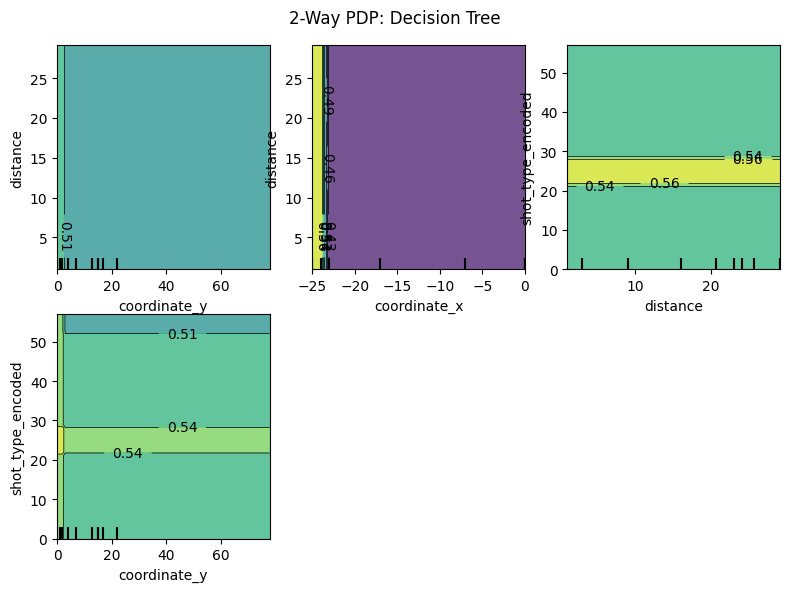

In [65]:
# 2-way PDP for feature interactions
interaction_features = [(1, 2), (0,2), (2,4), (1,4)]  
# For Linear Regression
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(dt_model, X_train, interaction_features, ax=ax)
plt.suptitle("2-Way PDP: Decision Tree")
plt.tight_layout()
plt.show()

In [71]:
# Define a wrapper for the DecisionTreeClassifier
class ModelWrapper:
    def __init__(self, model, feature_names):
        self.model = model
        self.feature_names = feature_names

    def predict_proba(self, X):
        # Convert NumPy array back to DataFrame with feature names
        X_df = pd.DataFrame(X, columns=self.feature_names)
        return self.model.predict_proba(X_df)

# Create a wrapped model
wrapped_model = ModelWrapper(dt_model, X_train.columns)

# Initialize LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Miss', 'Made'],
    mode='classification'
)

# Explain multiple instances
for i in range(0, 4):
    # Choose a single instance to explain
    instance_idx = i
    instance = X_test.iloc[instance_idx].values
    
    # Generate explanation
    lime_exp = lime_explainer.explain_instance(instance, wrapped_model.predict_proba)
    lime_exp.show_in_notebook(show_table=True)


In [ ]:
# foi top